Example Sudoku reader: https://www.youtube.com/watch?v=qOXDoYUgNlU&t=1505s

# Load packages

In [1]:
import cv2
import numpy as np
import tensorflow as tf

# Define useful functions

In [2]:
def compute_biggest_contour(contours):
    '''
    Loop through every contour to find the one with largest area __that is a square__
    
    Utilizing max(contour) will return the points that create the largest contour ... but not the corners
    
    Utilizing cv2.approxPolyDP(img,epsilon,closed_fig=True)
        - We are returned the verticies of a polygon
        - If len(approxPolyDP) == 4 --- it is a square object
    '''
    max_area = 0
    biggest = np.array([])
    for i in contours:
        area = cv2.contourArea(i) #Compute area of each contour
        if area > 50:
            peri = cv2.arcLength(i,True) #Compute perimeter for better accuracy in next function's Epsilon arg
            approx = cv2.approxPolyDP(i,0.02*peri,True) #Find the corners of a polygon
            if area > max_area and len(approx) == 4: #If there are exactly 4 points .. its a square! --> we're interested
                biggest = approx
                max_area = area
    return biggest,max_area

In [3]:
def reorder_corners(polygon):
    '''
    Returns the 4 corners of a contour as [top,left,right,bottom]
    '''
    polygon = polygon.reshape((4,2))
    new_array = np.zeros((4,2),dtype=np.int32)
    added = polygon.sum(1) #Result converts (4,2) to (4,1)
    
    #Top corner will be located where the sum of (x,y) pairs is largest
    new_array[0] = polygon[np.argmax(added)]
    
    #Bottom corner is where they sum to the smallest
    new_array[3] = polygon[np.argmin(added)]
    
    diff = np.diff(polygon,axis=1) #This time .. subtract x-y
    
    #Left corner is where the sum is largest
    new_array[1] = polygon[np.argmax(diff)]
    
    #Right corner is where the sum is smallest
    new_array[2] = polygon[np.argmin(diff)]
    
    return new_array

In [4]:
def box(img):
    '''
    Covert grid image into 81 boxes
    '''
    rows = np.vsplit(img,9) #(row by y)*9 entries
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9) #split each (row by y) into (row by col)*9
        for c in cols:
            boxes.append(c) #Append to list
    return boxes

In [5]:
def display_boxes(boxes):
    '''
    Optional function to display the individual box images
    '''
    import matplotlib.pyplot as plt

    fig,ax = plt.subplots(9,9)

    for i,j in enumerate(boxes):
        plt.subplot(9,9,i+1)
        plt.imshow(j,cmap='gray', vmin=0, vmax=255)
        plt.axis("off")
    plt.show()
    
def disp(box,resize=False,save=False,name=""):
    if resize:
        x,y = box.shape
        #Preprocessing
        box = cv2.resize(img[margin:y-margin,margin:x-margin],(28,28)) #Crop & shape to the input size of the trained model
    
    import matplotlib.pyplot as plt
    plt.imshow(box,cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    if save:
        plt.savefig(name)    
    plt.show()


In [6]:
def preprocess_images(img):
    data = []
    for img in boxes:
        data.append(np.resize(img,(28,28))) #Apply resize + Antialias this time
    return data

In [7]:
def model_predict(boxes,model):
    predictions = []
    margin = 9 #Define some arbitrary amount of pixels to pad off the edges of the images
    for img in boxes:
        x,y = img.shape
        #Preprocessing
        image = cv2.resize(img[margin:y-margin,margin:x-margin],(28,28)) #Crop & shape to the input size of the trained model
        image = image/255 #Just to keep things in [0,1] instead of [0,255] range
        image = np.reshape(image,(1,28,28,1)) #Reshape to appropriate dimension of the model
        image = -image #Invert color scheme because the MNIST dataset was black background white numbers (this is white background black numbers)
        #Predict
        pred = model.predict(image)
        #Grab necessary information
        class_id = np.argmax(pred)
        confidence = np.amax(pred)
        predictions.append([class_id,confidence])
    return predictions

In [8]:
def load_model(model="my_model.h5"):
    '''
    Define a function to load the model ... 
    I think this is to prevent some issues with tf keeping the model in memory otherwise
    '''
    m = tf.keras.models.load_model(model)
    return m

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 682912578058118358
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6959755424
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15914469061402422057
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:2b:00.0, compute capability: 7.5"
]


'/device:GPU:0'

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read image

In [12]:
#1) Load image
#original = cv2.imread("Sudoku1_rotated.png")
original = cv2.imread("Sudoku3.png")
y,x,_ = original.shape

#Set parameter `im_size` to the larger of x or y
if x > y:
    im_size = x
else:
    im_size = y

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
    
    

good = True

while good:
    #Show image
    #cv2.imshow("Original",original) #Display original image

    #2) Convert to gray scale
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    #3) Find contours
    edged = cv2.Canny(gray, 30, 200)
    contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

    contour_image = original.copy() #Copy the original image
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  #Draw on "contour_image" the "contours" (-1 = all contours) 
                                                                   #with color "(0,255,0)" (BGR) and thinkness of 2
    
    #cv2.imshow('Contours', contour_image) #Display the contours
    
    #4a) (Optional) plotting the largest contour
    c = max(contours, key = cv2.contourArea)
    c = c.reshape(len(c),2) #Converting (rows of pts,1,[y,x]) to (rows of pts,[y,x])

    square = original.copy()
    # draw the biggest contour (c) in magenta
    cv2.drawContours(square,[c],0,(175,0,150),2)

    #4b) Find the largest contour --- this will likely be the sudoku square
    dots = original.copy()
    biggest,_ = compute_biggest_contour(contours)
    for i in biggest:
        cv2.circle(dots, (i[0][0],i[0][1]), radius=10, color=(0, 0, 255), thickness=-1) #Testing to see that my function plots things correctly (had to trial & error it)    
    
    #5) Warp the perspective so the grid is flat
    biggest = reorder_corners(biggest)
    pt1 = np.array(biggest, dtype='float32')
    pt2 = np.float32([[y,x],[0,x],[y,0],[0,0] ])

    M = cv2.getPerspectiveTransform(pt1,pt2)

    warped = cv2.warpPerspective(original,M,(y-y%9,x-x%9),flags=cv2.INTER_LINEAR)
    warped = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY) #Convert the warped image to gray scale
    
    #6) Clean up the grid
    thresh = cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,
                                   349, #Block size (how many neighbors define an area) -- larger = less noise
                                   30) #C --- the value subtracted from everything to determine if it is above a threshold #
    
    #7) Split grid into 81 individual images
    boxes = box(thresh)
    #display_boxes(boxes) #Display the boxes as images (optional)
    
    #8) Load images into Tensorflow model predict
    model = load_model('my_model_4Conv_dropout_18ep.h5') #Load in the trained model
    predictions = model_predict(boxes,model)
    
    #Predict on boxes
    
    
    cv2.imshow("Row 1",np.hstack([original,contour_image,square,dots])) #Display everything
    cv2.imshow("Row 2",np.hstack([warped,thresh])) #Display everything
    
    #Block to allow breakage of code without Ctrl+C
    if cv2.waitKey(0)==27: #code 27 = ESC key
        good = False
cv2.destroyAllWindows() #Close all windows generated by cv2 commands

# Save individual cell images to run on sudoku model...

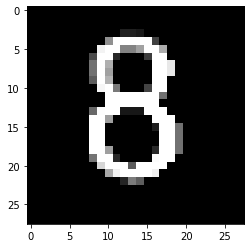

(array([[0.12770656, 0.10492215, 0.08559685, 0.16831276, 0.10244622,
         0.07253657, 0.12891746, 0.11721693, 0.09234459]], dtype=float32),
 4,
 0.16831276)

In [18]:
import glob
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython import display
import matplotlib.pyplot as plt

model2 = load_model('my_model_dropout_22ep.h5') #Load in the trained model
margin = 9 #Define some arbitrary amount of pixels to pad off the edges of the images
for img in boxes:
    #Preprocessing
    image = cv2.resize(img[margin:y-margin,margin:x-margin],(28,28)) #Crop & shape to the input size of the trained model
    image = image/255 #Just to keep things in [0,1] instead of [0,255] range
    image = -image #Invert colors
    plt.imshow(image,cmap='gray')
    plt.show()
    
    image = np.reshape(image,(1,28,28,1)) #Reshape to appropriate dimension of the model
    #Predict
    pred = model2.predict(image)
    #Grab necessary information
    class_id = np.argmax(pred) + 1 #Add 1 to adjust for class id being [0,8] instead of [1,9]
    confidence = np.amax(pred)
    break
pred,class_id,confidence

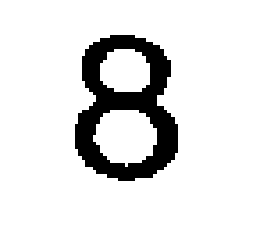

In [23]:
disp(img[margin:y-margin,margin:x-margin])

In [13]:
predictions

[[7, 0.1289336],
 [0, 0.1338971],
 [0, 0.1339564],
 [0, 0.1338971],
 [0, 0.13167329],
 [0, 0.13383338],
 [0, 0.1338971],
 [0, 0.1338971],
 [7, 0.12907667],
 [0, 0.1338971],
 [7, 0.12955815],
 [0, 0.13389851],
 [7, 0.12934938],
 [0, 0.1338971],
 [0, 0.12964538],
 [0, 0.1338971],
 [0, 0.1311944],
 [0, 0.1338971],
 [0, 0.1338971],
 [0, 0.1338971],
 [7, 0.12969784],
 [0, 0.1338971],
 [7, 0.12853588],
 [0, 0.1338971],
 [7, 0.12957025],
 [0, 0.1338971],
 [0, 0.13384467],
 [0, 0.1338971],
 [7, 0.12841332],
 [0, 0.13384631],
 [0, 0.12936975],
 [0, 0.1338971],
 [0, 0.13080052],
 [0, 0.1338971],
 [7, 0.12943645],
 [0, 0.1338971],
 [7, 0.13064697],
 [0, 0.1338971],
 [7, 0.12912144],
 [0, 0.1338971],
 [7, 0.12779078],
 [0, 0.1338971],
 [0, 0.12965891],
 [0, 0.1338971],
 [7, 0.12952206],
 [0, 0.1338971],
 [0, 0.13003887],
 [0, 0.13398482],
 [7, 0.1300187],
 [0, 0.1338971],
 [7, 0.1295403],
 [0, 0.1338971],
 [7, 0.12932876],
 [0, 0.13418531],
 [0, 0.1338971],
 [0, 0.1338971],
 [0, 0.13001795],
 [0, 

In [9]:
a = cv2.resize(boxes[0],(28,28))
a = a.reshape(1,28,28,1)

print(a,a.shape)

predictions = model.predict(a)

class_idx = np.argmax(predictions)
acc = np.amax(predictions)

print(predictions)
print(class_idx,acc)

[[[[ 84]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [ 64]
   [194]
   [ 84]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]]

  [[ 20]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [255]
   [255]
   [255]
   [255]
   [255]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [191]
   [ 75]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [255]
   [

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv2d/Conv2D (defined at <ipython-input-9-4f57fd35a614>:6) ]] [Op:__inference_predict_function_867]

Function call stack:
predict_function


Display one of the boxes as resized image & run prediction

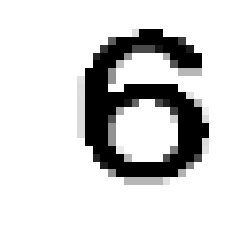

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv2d/Conv2D (defined at <ipython-input-11-3c3384412829>:10) ]] [Op:__inference_predict_function_866]

Function call stack:
predict_function


In [11]:
img_num = 40
x,y = boxes[img_num].shape
margin = 9
crop_img = boxes[img_num][margin:y-margin,margin:x-margin]
disp(crop_img,resize=True)

#Now try and feed to predictor
crop_img = cv2.resize(crop_img.shape,(28,28)) #Resize
crop_img = np.reshape(crop_img,(1,28,28,1)) #Reshape
guess = model.predict(crop_img)